候选（前10）: ['N1024_rd0.00.log', 'N2048_rd0.00.log', 'N4096_rd0.00.log', 'N8192_rd0.00.log', 'N16384_rd0.00.log', 'N32768_rd0.00.log', 'N65536_rd0.00.log', 'N131072_rd0.00.log']
找到日志数量: 8
Parsed ./N1024_rd0.00.log
Parsed ./N2048_rd0.00.log
Parsed ./N4096_rd0.00.log
Parsed ./N8192_rd0.00.log
Parsed ./N16384_rd0.00.log
Parsed ./N32768_rd0.00.log
Parsed ./N65536_rd0.00.log
Parsed ./N131072_rd0.00.log


,file,N,ratio_dyn,final_train_loss,final_valid_loss,final_train_acc,final_valid_acc,final_total_cos_loss,final_vocab_cro_loss,final_dyn_dyn_cos_loss,final_dyn_sta_cos_loss
0,N1024_rd0.00.log,1024,0.0,1.0256,1.5758,0.6885,0.5586,0.14754,1.02495,3.11292,0.14754
1,N2048_rd0.00.log,2048,0.0,1.0787,1.5779,0.6821,0.5605,0.10833,1.08150,3.18990,0.10833
2,N4096_rd0.00.log,4096,0.0,1.0899,1.5785,0.6711,0.5625,0.08503,1.08909,3.26217,0.08503
3,N8192_rd0.00.log,8192,0.0,1.1137,1.5782,0.6592,0.5625,0.06985,1.11438,3.18559,0.06985
4,N16384_rd0.00.log,16384,0.0,1.1130,1.5804,0.6590,0.5586,0.06529,1.11345,3.23039,0.06529
5,N32768_rd0.00.log,32768,0.0,1.1133,1.5751,0.6591,0.5586,0.06139,1.11333,3.31927,0.06139
6,N65536_rd0.00.log,65536,0.0,1.1162,1.5912,0.6604,0.5645,0.06319,1.11601,3.27403,0.06319
7,N131072_rd0.00.log,131072,0.0,1.1190,1.5585,0.6588,0.5586,0.05611,1.11891,3.28645,0.05611


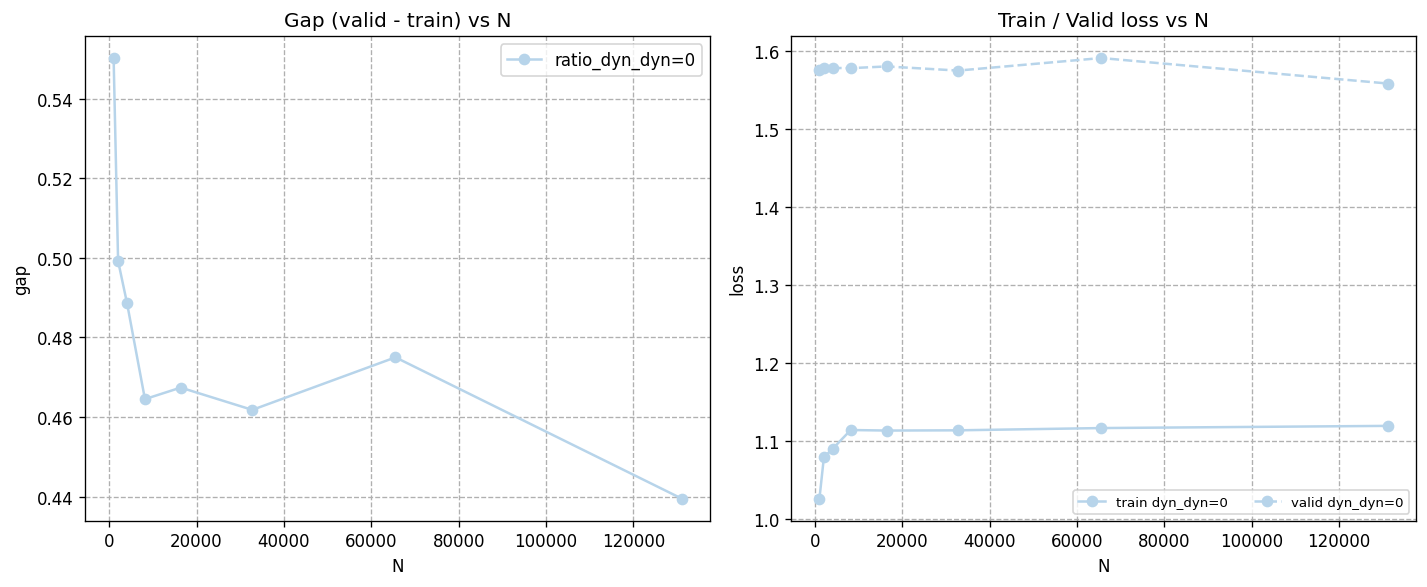

In [2]:
# =========================
# Step 0: 依赖
# =========================
import os, re
from typing import Dict, List, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

# =========================
# Step 1: 文件名生成 / 收集
# =========================
def make_log_filename(N: int, ratio_dyn: str, prefix: str = "N") -> str:
    # 你的文件名形如: N{N}_rd{ratio}.log   (ratio 如 0.00, 0.05, ...)
    return f"{prefix}{N}_rd{ratio_dyn}.log"

def make_log_filenames(N_list, ratio_list, prefix="N") -> List[str]:
    return [make_log_filename(N, r, prefix) for N in N_list for r in ratio_list]

def list_existing_logs(log_dir: str, candidates: List[str]) -> List[str]:
    return [os.path.join(log_dir, f) for f in candidates if os.path.exists(os.path.join(log_dir, f))]

# =========================
# Step 2: 解析引擎（单文件）
# =========================
FNAME_RE = re.compile(r"^N(?P<N>\d+)_rd(?P<rd>[0-9.]+)\.log$")

FLOAT = r"[-+]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][-+]?\d+)?"

# 训练阶段两类行：
TRAIN_SUMMARY_RE = re.compile(
    r"^epoch\s+(\d+)\s+summary:\s+"
    r"dyn_dyn_cos_loss:\s*(" + FLOAT + r")\s*,\s*"
    r"dyn_sta_cos_loss:\s*(" + FLOAT + r")\s*,\s*"
    r"total_cos_loss\s*:\s*(" + FLOAT + r")\s*,\s*"
    r"vocab_cro_loss\s*:\s*(" + FLOAT + r")\s*,\s*$"
)
TRAIN_LINE_RE = re.compile(r"^train loss:\s*(" + FLOAT + r")\s*,\s*train acc:\s*(" + FLOAT + r")\s*$")

# 验证阶段行：
VALID_LINE_RE = re.compile(r"^valid loss:\s*(" + FLOAT + r")\s*,\s*valid acc:\s*(" + FLOAT + r")\s*$")

def parse_filename_meta(filename: str) -> Dict[str, Any]:
    m = FNAME_RE.match(filename)
    if not m:
        return {"file": filename, "N": None, "ratio_dyn": None}
    return {
        "file": filename,
        "N": int(m.group("N")),
        "ratio_dyn": float(m.group("rd")),
    }

def parse_log_file(filepath: str) -> Dict[str, Any]:
    meta = parse_filename_meta(os.path.basename(filepath))
    series: Dict[str, List[float]] = {
        "dyn_dyn_cos_loss": [], "dyn_sta_cos_loss": [], "total_cos_loss": [], "vocab_cro_loss": [],
        "train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": [],
    }
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()

            ms = TRAIN_SUMMARY_RE.match(line)
            if ms:
                series["dyn_dyn_cos_loss"].append(float(ms.group(2)))
                series["dyn_sta_cos_loss"].append(float(ms.group(3)))
                series["total_cos_loss"].append(float(ms.group(4)))
                series["vocab_cro_loss"].append(float(ms.group(5)))
                continue

            mt = TRAIN_LINE_RE.match(line)
            if mt:
                series["train_loss"].append(float(mt.group(1)))
                series["train_acc"].append(float(mt.group(2)))
                continue

            mv = VALID_LINE_RE.match(line)
            if mv:
                series["valid_loss"].append(float(mv.group(1)))
                series["valid_acc"].append(float(mv.group(2)))
                continue

    return {"meta": meta, "series": series}

# =========================
# Step 3: 批量解析
# =========================
def parse_multiple_logs(filepaths: List[str]) -> List[Dict[str, Any]]:
    runs = []
    for p in filepaths:
        try:
            runs.append(parse_log_file(p))
            print(f"Parsed {p}")
        except Exception as e:
            runs.append({"meta": {"file": os.path.basename(p), "N": None, "ratio_dyn": None},
                         "series": {}, "error": str(e)})
    return runs

# =========================
# Step 4: 聚合（末尾指标）
# =========================
def build_final_table(runs: List[Dict[str, Any]]) -> pd.DataFrame:
    def last_or_nan(lst):
        return lst[-1] if lst else float("nan")

    rows = []
    for r in runs:
        meta = r.get("meta", {})
        s    = r.get("series", {})
        rows.append({
            "file": meta.get("file"),
            "N": meta.get("N"),
            "ratio_dyn": meta.get("ratio_dyn"),
            "final_train_loss": last_or_nan(s.get("train_loss", [])),
            "final_valid_loss": last_or_nan(s.get("valid_loss", [])),
            "final_train_acc":  last_or_nan(s.get("train_acc", [])),
            "final_valid_acc":  last_or_nan(s.get("valid_acc", [])),
            "final_total_cos_loss": last_or_nan(s.get("total_cos_loss", [])),
            "final_vocab_cro_loss": last_or_nan(s.get("vocab_cro_loss", [])),
            "final_dyn_dyn_cos_loss": last_or_nan(s.get("dyn_dyn_cos_loss", [])),
            "final_dyn_sta_cos_loss": last_or_nan(s.get("dyn_sta_cos_loss", [])),
        })
    df = pd.DataFrame(rows)
    return df.sort_values(["ratio_dyn","N"])

# =========================
# Step 5: 绘图（单张：左 gap=valid-train；右 train/valid）
# =========================
def _colors_for_ratios(ratios):
    # 由浅到深（小→大）
    r_sorted = sorted(ratios)
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(r_sorted)))
    return {r: colors[i] for i, r in enumerate(r_sorted)}

def plot_gap_and_losses_by_ratio(df: pd.DataFrame, title_suffix: str = ""):
    if df.empty:
        print("No data to plot.")
        return

    # 确保 N 有序
    df = df.copy().sort_values(["ratio_dyn","N"])
    df["gap"] = df["final_valid_loss"] - df["final_train_loss"]

    cmap = _colors_for_ratios(df["ratio_dyn"].dropna().unique())

    fig, (axL, axR) = plt.subplots(1, 2, figsize=(12, 5), sharex=False)

    # 左：gap
    for ratio, grp in df.groupby("ratio_dyn"):
        g = grp.sort_values("N")
        axL.plot(g["N"], g["gap"], marker="o", linestyle="-", color=cmap[ratio], label=f"ratio_dyn_dyn={ratio:g}")
    axL.set_title(f"Gap (valid - train) vs N{title_suffix}")
    axL.set_xlabel("N"); axL.set_ylabel("gap")
    axL.grid(True, ls="--"); axL.legend()

    # 右：train / valid
    for ratio, grp in df.groupby("ratio_dyn"):
        g = grp.sort_values("N")
        axR.plot(g["N"], g["final_train_loss"], marker="o", linestyle="-",  color=cmap[ratio], label=f"train dyn_dyn={ratio:g}")
        axR.plot(g["N"], g["final_valid_loss"], marker="o", linestyle="--", color=cmap[ratio], label=f"valid dyn_dyn={ratio:g}")
    axR.set_title(f"Train / Valid loss vs N{title_suffix}")
    axR.set_xlabel("N"); axR.set_ylabel("loss")
    axR.grid(True, ls="--"); axR.legend(ncol=2, fontsize=8)

    plt.tight_layout()
    plt.show()

# =========================
# Step 6: 示例（按需启用）
# =========================
# 日志目录与范围（与你当前生成命令一致）
log_dir   = "."
# N 从 1024 开始，按 2 倍到 131072
N_list    = [1024*(2**k) for k in range(0, 8)]  # 1024, 2048, ..., 131072
# ratio 按你的字符串格式，确保与文件名完全一致
ratio_list = ["0.00"] # ,"0.05","0.10","0.20","0.40","0.80", "1.00"]

candidates = make_log_filenames(N_list, ratio_list)
print("候选（前10）:", candidates[:10])

filepaths = list_existing_logs(log_dir, candidates)
print("找到日志数量:", len(filepaths))

runs = parse_multiple_logs(filepaths)
df_final = build_final_table(runs)

# 汇总表（可选）
display(df_final)

# 单张图：左 gap=valid-train；右分别的 train/valid（同色：实线/虚线）
plot_gap_and_losses_by_ratio(df_final, title_suffix="")
